## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:39<00:00, 4.34MB/s] 


In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

## Creating Data Loader

In [6]:
train_loader = DataLoader(
    train_data,
    batch_size=10,
    shuffle=True
)

test_loader = DataLoader(
    test_data,
    batch_size=10,
    shuffle=False
)

## Examine Batch of Images

In [7]:
class_names = [
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

In [8]:
for images, labels in train_loader:
    break

In [9]:
images.shape

torch.Size([10, 3, 32, 32])

In [10]:
labels

tensor([0, 2, 4, 4, 8, 1, 9, 0, 5, 2])

Labels: [0 2 4 4 8 1 9 0 5 2]
Class plane bird deer deer ship car truck plane dog bird


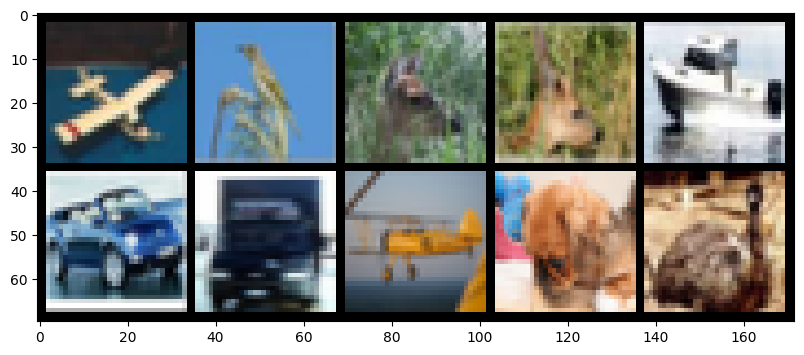

In [11]:
print(f"Labels: {labels.numpy()}")
print("Class", *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(), (1,2,0)));

## Creating Model

In [12]:
images[0].shape

torch.Size([3, 32, 32])

In [13]:
(((32-2)/2)-2)/2

6.5

In [14]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=6*6*16, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(input=X, kernel_size=2, stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(input=X, kernel_size=2, stride=2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [15]:
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
parameter_list = []
for param in model.parameters():
    parameter_list.append(param.numel())

print(f"Total Number of Parameters: {sum(parameter_list)}")

Total Number of Parameters: 81590


## Training the Model

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()

epochs = 5
train_losses_list = []
test_losses_list = []
train_correct_list = []
test_correct_list = []

for i in range(epochs):
    train_correct = 0
    test_correct = 0

    for batch, (X_train, y_train) in enumerate(train_loader):
        batch += 1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_correct = (predicted == y_train).sum()
        train_correct += batch_correct

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 600 == 0:
            print(f"EPOCH: {i} BATCH: {batch} LOSS: {loss.item()} ACCURACY: {train_correct.item()*100/(batch*10):7.3f}%")

    train_losses_list.append(loss.detach().numpy())
    train_correct_list.append(train_correct)

    # Testing
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses_list.append(loss.detach().numpy())
    test_correct_list.append(test_correct)


current_time = time.time()
total_time = current_time - start_time
print(f"Training Took {total_time/60} minutes")

EPOCH: 0 BATCH: 600 LOSS: 1.7361781597137451 ACCURACY:  23.983%
EPOCH: 0 BATCH: 1200 LOSS: 1.390074372291565 ACCURACY:  29.092%
EPOCH: 0 BATCH: 1800 LOSS: 1.8126142024993896 ACCURACY:  32.711%
EPOCH: 0 BATCH: 2400 LOSS: 2.0553462505340576 ACCURACY:  34.996%
EPOCH: 0 BATCH: 3000 LOSS: 1.1197059154510498 ACCURACY:  36.913%
EPOCH: 0 BATCH: 3600 LOSS: 1.1415085792541504 ACCURACY:  38.400%
EPOCH: 0 BATCH: 4200 LOSS: 2.0813651084899902 ACCURACY:  39.698%
EPOCH: 0 BATCH: 4800 LOSS: 1.1910514831542969 ACCURACY:  40.808%
EPOCH: 1 BATCH: 600 LOSS: 1.436012864112854 ACCURACY:  50.833%
EPOCH: 1 BATCH: 1200 LOSS: 0.9246759414672852 ACCURACY:  50.742%
EPOCH: 1 BATCH: 1800 LOSS: 1.1908222436904907 ACCURACY:  51.344%
EPOCH: 1 BATCH: 2400 LOSS: 1.2964916229248047 ACCURACY:  51.350%
EPOCH: 1 BATCH: 3000 LOSS: 1.2928812503814697 ACCURACY:  51.713%
EPOCH: 1 BATCH: 3600 LOSS: 0.877383828163147 ACCURACY:  51.950%
EPOCH: 1 BATCH: 4200 LOSS: 1.600054144859314 ACCURACY:  52.090%
EPOCH: 1 BATCH: 4800 LOSS: 1.15

In [ ]:
plt.plot(train_losses_list, label='Train Loss')
plt.plot(test_losses_list, label='Validation Loss')
plt.title("Loss at Epoch")
plt.legend();

In [ ]:
plt.plot([train/500 for train in train_correct_list], label='Train Accuracy')
plt.plot([test/100 for test in test_correct_list], label='Validation Accuracy')
plt.title("Accuracy at Epoch")
plt.legend();

## Saving the Model

In [ ]:
torch.save(model.state_dict(), 'cifar10_model.pt')

## Evaluate Test Data

In [ ]:
test_load_all = DataLoader(
    dataset=test_data,
    batch_size=10000,
    shuffle=False
)

In [ ]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test).sum()

In [ ]:
correct.item() * 100 / 10000

In [ ]:
print(classification_report(y_true=predicted.view(-1), y_pred=y_test.view(-1)))

In [ ]:
plt.figure(figsize=(10,6))
matrix = confusion_matrix(y_true=predicted.view(-1), y_pred=y_test.view(-1))
df_confusion_matrix = pd.DataFrame(matrix, class_names, class_names)
sns.heatmap(df_confusion_matrix, annot=True, fmt='1.0f')
plt.xlabel("Prediction")
plt.ylabel("Actual");